<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Data-exploration-and-visualization" data-toc-modified-id="Data-exploration-and-visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data exploration and visualization</a></span><ul class="toc-item"><li><span><a href="#Visualizations-by-player-(data-since-2016)" data-toc-modified-id="Visualizations-by-player-(data-since-2016)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Visualizations by player (data since 2016)</a></span></li><li><span><a href="#Visualizations-by-Year" data-toc-modified-id="Visualizations-by-Year-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visualizations by Year</a></span></li><li><span><a href="#Wacky-Tangotiger-Shit" data-toc-modified-id="Wacky-Tangotiger-Shit-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Wacky Tangotiger Shit</a></span></li></ul></li></ul></div>

# 3.0 Launch Angle Profiles
Investigating different players' launch angles visually, because averages suck.

## Libraries

In [3]:
import os

import pandas as pd
import numpy as np

from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

## Data

In [4]:
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS_PATH = os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json')

In [8]:
params = {
    'year_filter': 'game_year >= 2016',
    'game_type': 'R'
}

In [58]:
SQL = \
"""
SELECT
  t_events.event_id AS event_id,
  t_events.batter_id AS batter_id,
  t_batter.mlb_name AS batter_name,
  t_events.pitcher_id AS pitcher_id,
  t_pitcher.mlb_name AS pitcher_name,
  t_events.at_bat_key AS at_bat_key,
  t_events.game_pk AS game_pk,
  t_events.at_bat_number AS at_bat_number,
  t_events.pitch_number AS pitch_number,
  t_events.batter_team AS batter_team,
  t_events.pitcher_team AS pitcher_team,
  t_events.batter_side AS batter_side,
  t_events.pitcher_side AS pitcher_side,
  t_events.description AS description,
  t_events.events AS events,
  t_events.bb_type AS bb_type,
  t_events.effective_speed AS effective_speed,
  t_events.release_speed AS release_speed,
  t_events.release_spin_rate AS release_spin_rate,
  t_events.release_pos_x AS release_pos_x,
  t_events.release_pos_z AS release_pos_z,
  t_events.break_horizontal AS break_horizontal,
  t_events.break_vertical AS break_vertical,
  t_events.zone AS zone,
  t_events.plate_x AS plate_x,
  t_events.plate_z AS plate_z,
  t_events.sz_top AS sz_top,
  t_events.sz_bot AS sz_bot,
  t_events.launch_speed AS launch_speed,
  t_events.launch_angle AS launch_angle,
  t_events.spray_angle AS spray_angle,
  t_events.hit_x AS hit_x,
  t_events.hit_y AS hit_y,
  t_events.hit_distance_sc AS hit_distance_sc,
  t_events.game_year AS game_year,
  (CASE WHEN t_events.events IN ('single', 'double', 'triple', 'home_run') THEN 1 ELSE 0 END) AS hit_flag,
  (CASE WHEN t_events.events = 'home_run' THEN 1 ELSE 0 END) AS hr_flag,
  (CASE WHEN t_events.description IN ('foul', 'foul_tip', 'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score', 'pitchout_hit_into_play', 'pitchout_hit_into_play_score', 'swinging_pitchout', 'swinging_strike', 'swinging_strike_blocked')
    THEN 1 ELSE 0 END) AS swung_flag,
  (CASE WHEN t_events.events IS NOT NULL AND t_events.events NOT IN ('caught_stealing_2b', 'caught_stealing_3b', 'caught_stealing_home', 'pickoff_1b', 'pickoff_2b', 'pickoff_caught_stealing_2b', 'pickoff_caught_stealing_3b', 'pickoff_caught_stealing_home')
    THEN 1 ELSE 0 END) AS final_pitch_flag,
  (CASE WHEN t_events.launch_speed IS NOT NULL AND t_events.launch_angle IS NOT NULL AND t_events.hit_distance_sc IS NULL
    THEN 1 ELSE 0 END) AS sc_fill_flag
FROM
  (
    SELECT
      event_id,
      batter AS batter_id,
      pitcher AS pitcher_id,
      CONCAT(game_pk, CAST(at_bat_number AS STRING)) AS at_bat_key,
      game_pk,
      at_bat_number,
      pitch_number,
      MAX(batter_team) AS batter_team,
      MAX(pitcher_team) AS pitcher_team,
      MAX(stand) AS batter_side,
      MAX(p_throws) AS pitcher_side,
      MAX(description) AS description,
      MAX(events) AS events,
      MAX(bb_type) AS bb_type,
      MAX(effective_speed) AS effective_speed,
      MAX(release_speed) AS release_speed,
      MAX(release_spin_rate) AS release_spin_rate,
      MAX(release_pos_x) AS release_pos_x,
      MAX(release_pos_z) AS release_pos_z,
      MAX(pfx_x) AS break_horizontal,
      MAX(pfx_z) AS break_vertical,
      MAX(zone) AS zone,
      MAX(plate_x) AS plate_x,
      MAX(plate_z) AS plate_z,
      MAX(sz_top) AS sz_top,
      MAX(sz_bot) AS sz_bot,
      MAX(launch_speed) AS launch_speed,
      MAX(launch_angle) AS launch_angle,
      MAX(spray_angle_est) AS spray_angle,
      MAX(hc_x) AS hit_x,
      MAX(hc_y) AS hit_y,
      MAX(hit_distance_sc) AS hit_distance_sc,
      MAX(game_year) AS game_year
    FROM
      `ad-fantasy-baseball.core.statcast_extended`
    WHERE
      game_type = '{game_type}'
          AND {year_filter}
    GROUP BY 1, 2, 3, 4, 5, 6, 7
  ) t_events
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `ad-fantasy-baseball.core.players`
  ) t_batter
    ON (t_events.batter_id = t_batter.mlb_id)
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `ad-fantasy-baseball.core.players`
  ) t_pitcher
    ON (t_events.pitcher_id = t_pitcher.mlb_id)
"""

In [59]:
sql = SQL.format(**params)
df_events = read_gbq(query=sql, dialect='standard', project_id=PROJECT_ID, private_key=CREDENTIALS_PATH)

df_true = df_events.copy()

In [60]:
df_events.head(5)

,event_id,batter_id,batter_name,pitcher_id,pitcher_name,at_bat_key,game_pk,at_bat_number,pitch_number,batter_team,...,spray_angle,hit_x,hit_y,hit_distance_sc,game_year,hit_flag,hr_flag,swung_flag,final_pitch_flag,sc_fill_flag
0,530413.53.1,606299,Jose Peraza,434628,Jason Hammel,53041353,530413,53,1,CIN,...,NaN,None,None,None,2018,0,0,0,0,0
1,530645.21.2,516416,Jean Segura,434628,Jason Hammel,53064521,530645,21,2,SEA,...,NaN,None,None,None,2018,0,0,0,0,0
2,530589.16.4,642547,Freddy Peralta,596001,Jake Junis,53058916,530589,16,4,MIL,...,NaN,None,None,None,2018,0,0,0,1,0
3,446988.51.3,460576,Carlos Gomez,570649,Yordano Ventura,44698851,446988,51,3,HOU,...,NaN,None,None,None,2016,0,0,0,0,0
4,491841.32.7,541645,Avisail Garcia,453178,Ian Kennedy,49184132,491841,32,7,CWS,...,NaN,None,None,None,2017,0,0,0,1,0


In [61]:
df_events.shape

(2153068, 40)

## Data Preparation

In [79]:
num_cols = [
    'effective_speed',
    'release_speed',
    'release_spin_rate',
    'release_pos_x',
    'release_pos_z',
    'break_horizontal',
    'break_vertical',
    'zone',
    'plate_x',
    'plate_z',
    'sz_top',
    'sz_bot',
    'launch_speed',
    'launch_angle',
    'hit_x',
    'hit_y',
    'hit_distance_sc'
]

df_events[num_cols] = df_events[num_cols].apply(pd.to_numeric)

In [80]:
_batted = df_events['bb_type'].notnull()
_hit = df_events['hit_flag'] == 1
_hr = df_events['hr_flag'] == 1
_sc_fill = df_events['sc_fill_flag'] == 1
_rhb = df_events['batter_side'] == 'R'
_lhb = df_events['batter_side'] == 'L'
_rhp = df_events['pitcher_side'] == 'R'
_lhp = df_events['pitcher_side'] == 'L'

In [81]:
df_launch = df_events[_batted & ~_sc_fill]
df_launch_no_hr = df_events[_batted & ~_sc_fill & ~_hr]

## Analysis

In [82]:
sns.set(rc={'figure.figsize':(16,9)})

### Visualizations by player (data since 2016)

In [83]:
batter_list = [
    'Mike Trout',
    'Aaron Judge',
    'Joey Gallo',
    'Ian Desmond'
]
df_player = df_launch[df_launch['batter_name'].isin(batter_list)]
df_player_no_hr = df_launch_no_hr[df_launch_no_hr['batter_name'].isin(batter_list)]

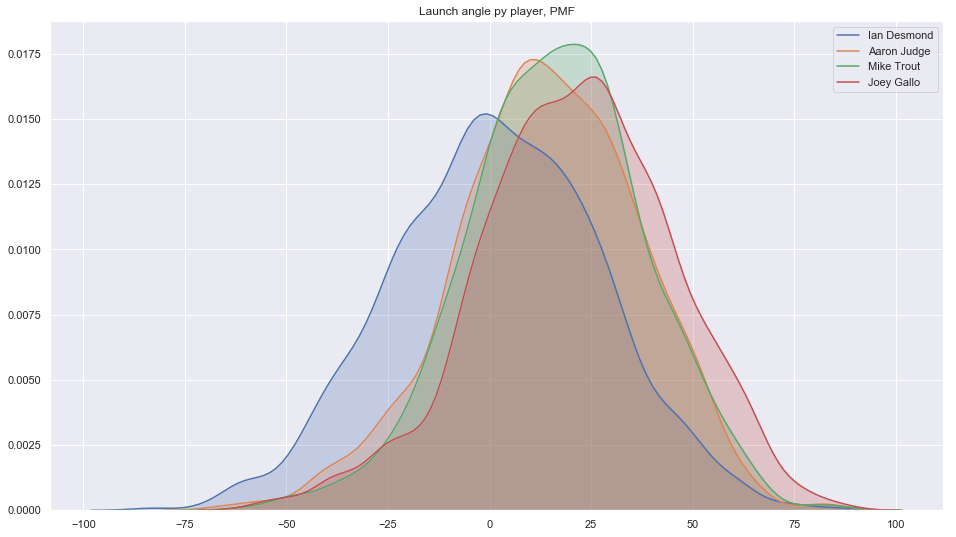

In [84]:
for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    sns.kdeplot(data=_df['launch_angle'], bw=5, label=batter, shade=True)
    
plt.title('Launch angle py player, PMF')
plt.show()

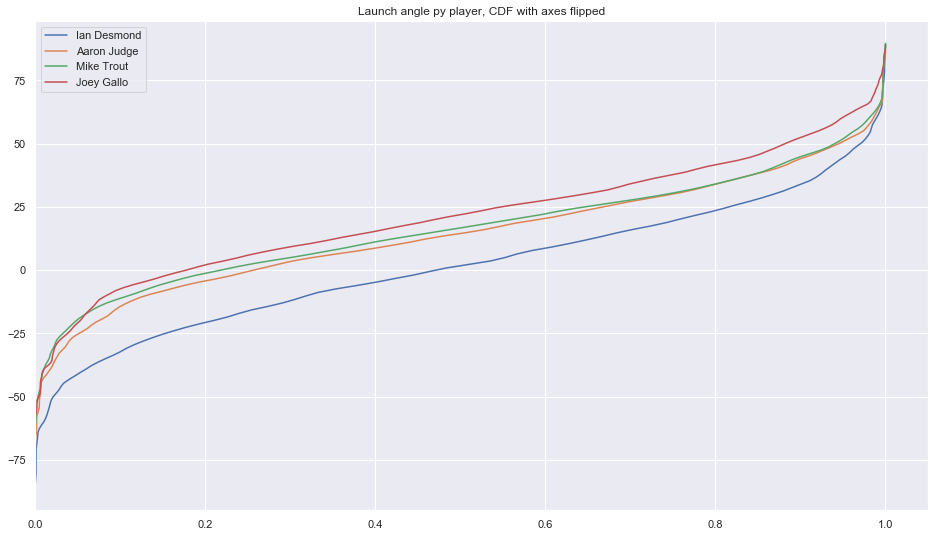

In [85]:
for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    sns.kdeplot(data=_df['launch_angle'], bw=1, label=batter, cumulative=True,
               vertical=True)
    
plt.title('Launch angle py player, CDF with axes flipped')
plt.show()

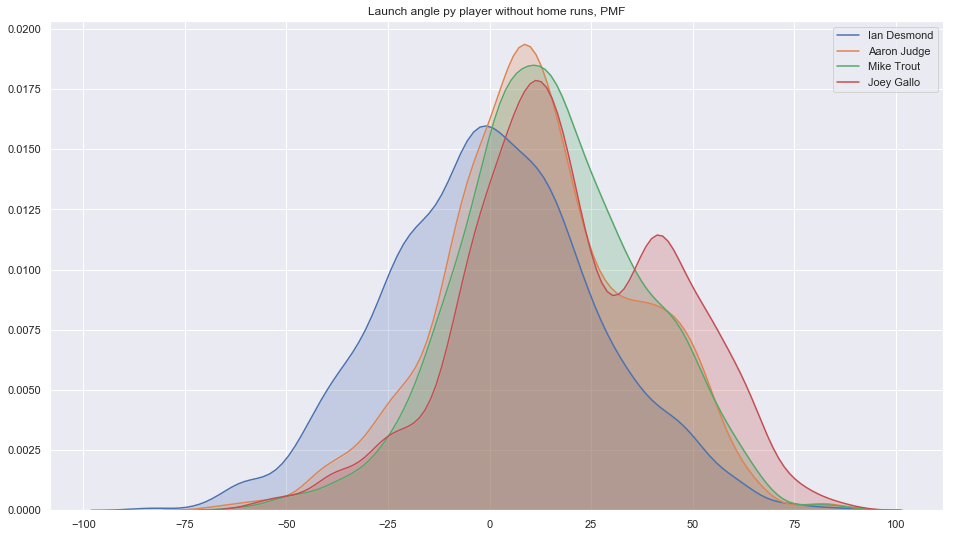

In [86]:
for batter in df_player_no_hr['batter_name'].unique():
    _df = df_player_no_hr[df_player_no_hr['batter_name'] == batter]
    sns.kdeplot(data=_df['launch_angle'], bw=5, label=batter, shade=True)
    
plt.title('Launch angle py player without home runs, PMF')
plt.show()

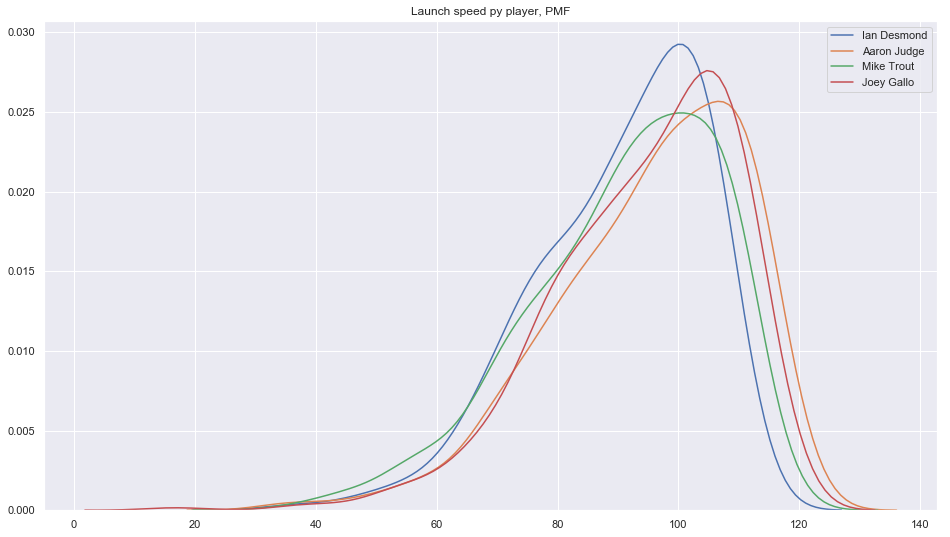

In [87]:
for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    sns.kdeplot(data=_df['launch_speed'], bw=5, label=batter)
    
plt.title('Launch speed py player, PMF')
plt.show()

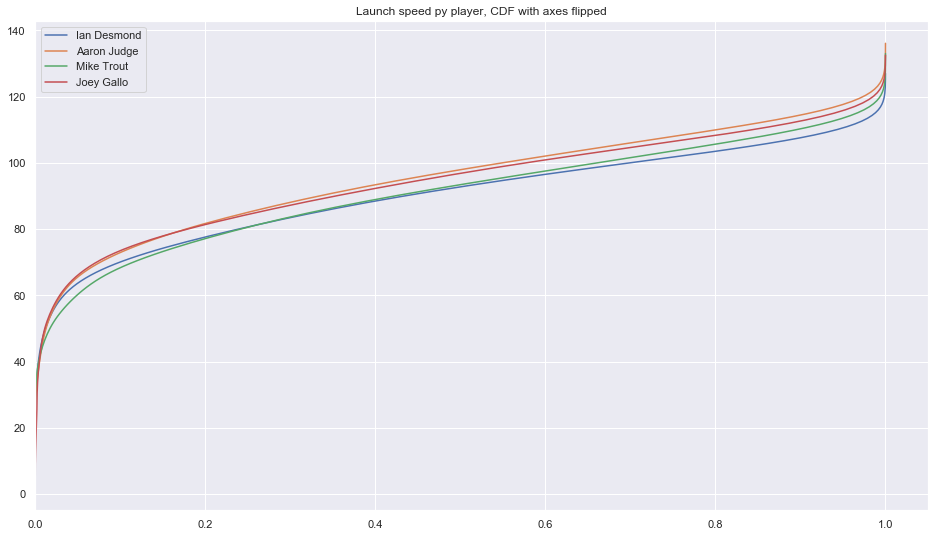

In [88]:
for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    sns.kdeplot(data=_df['launch_speed'], bw=5, label=batter, cumulative=True,
               vertical=True)
    
plt.title('Launch speed py player, CDF with axes flipped')
plt.show()

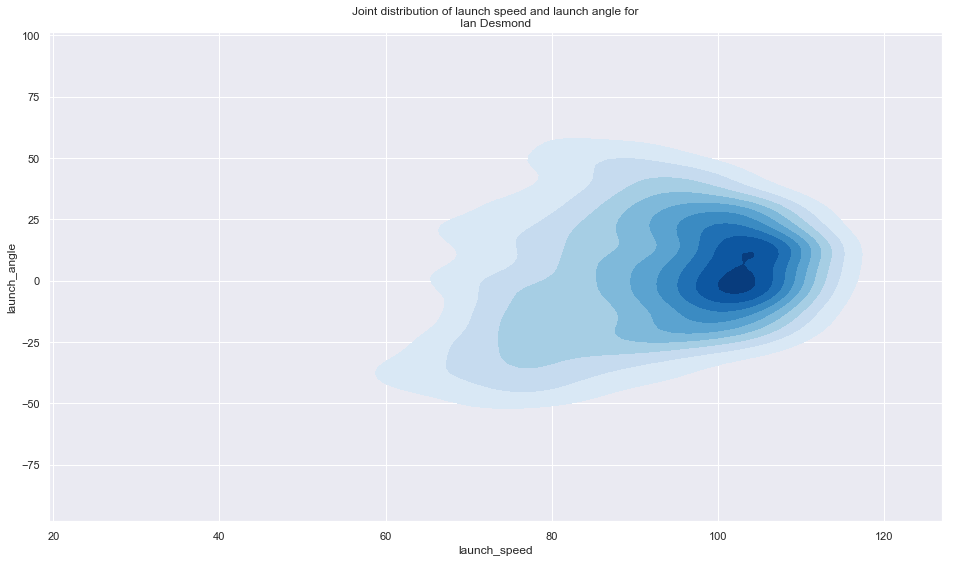

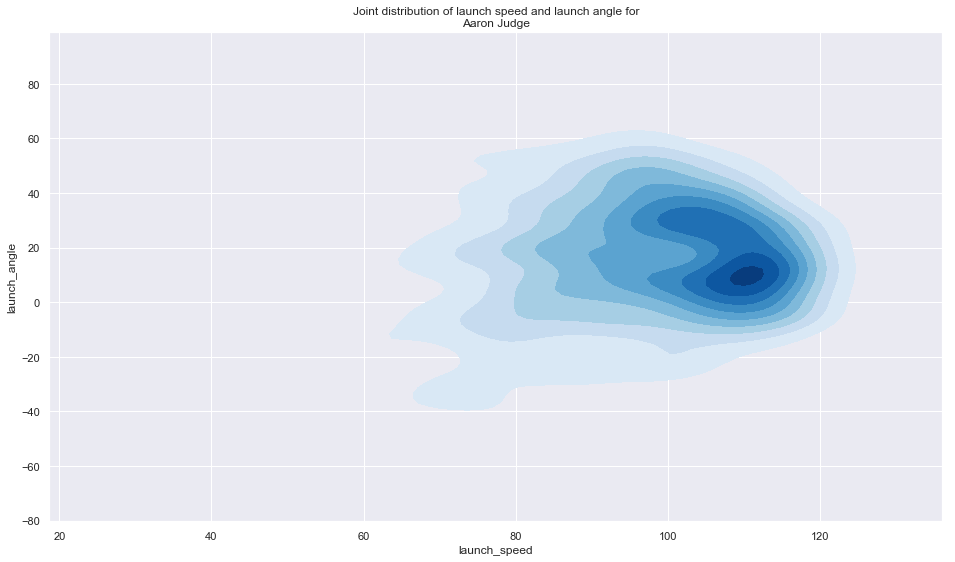

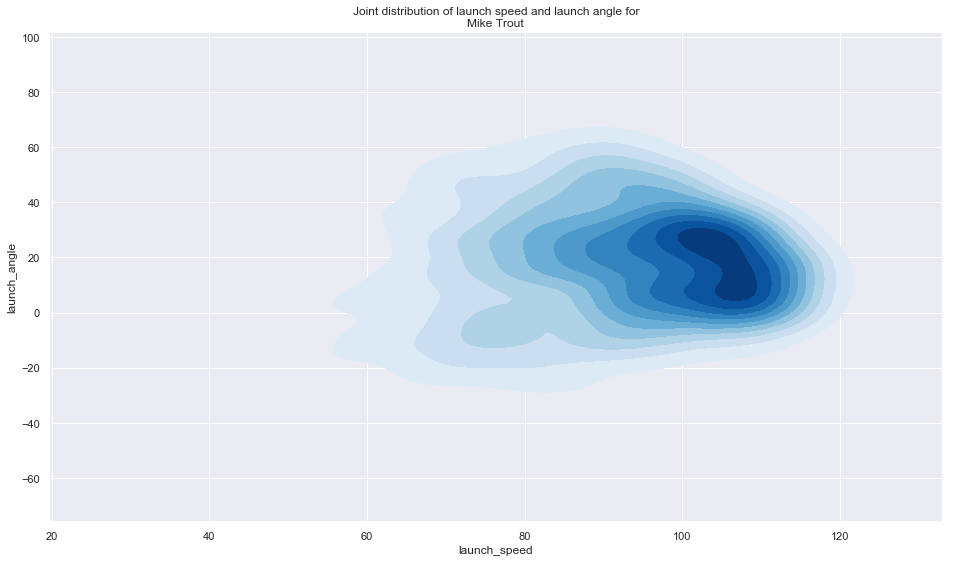

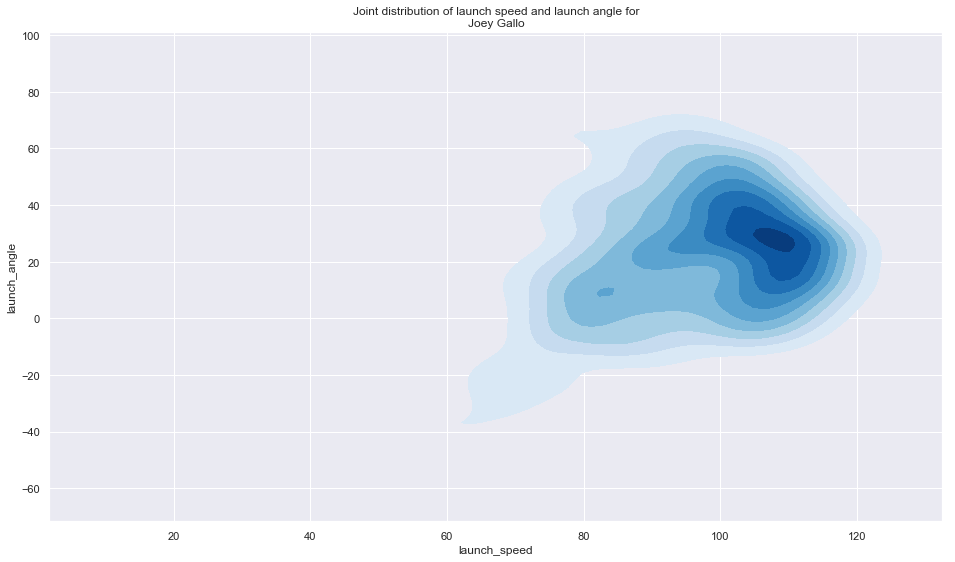

In [89]:
for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    sns.kdeplot(data=_df['launch_speed'],
                data2=_df['launch_angle'],
                bw=5,
                shade=True,
                shade_lowest=False,
                cmap='Blues')
    
    plt.title('Joint distribution of launch speed and launch angle for\n{}'.format(batter))
    plt.show()

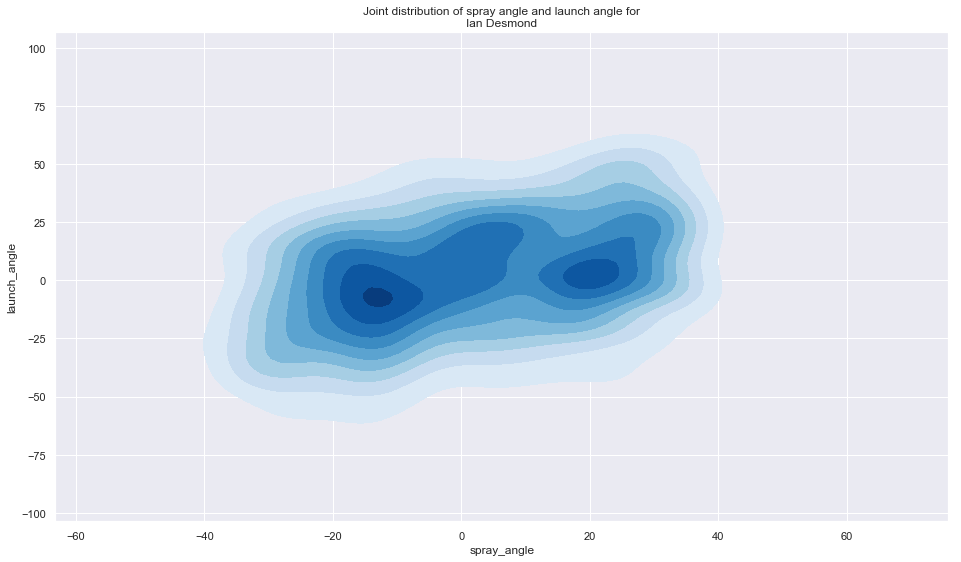

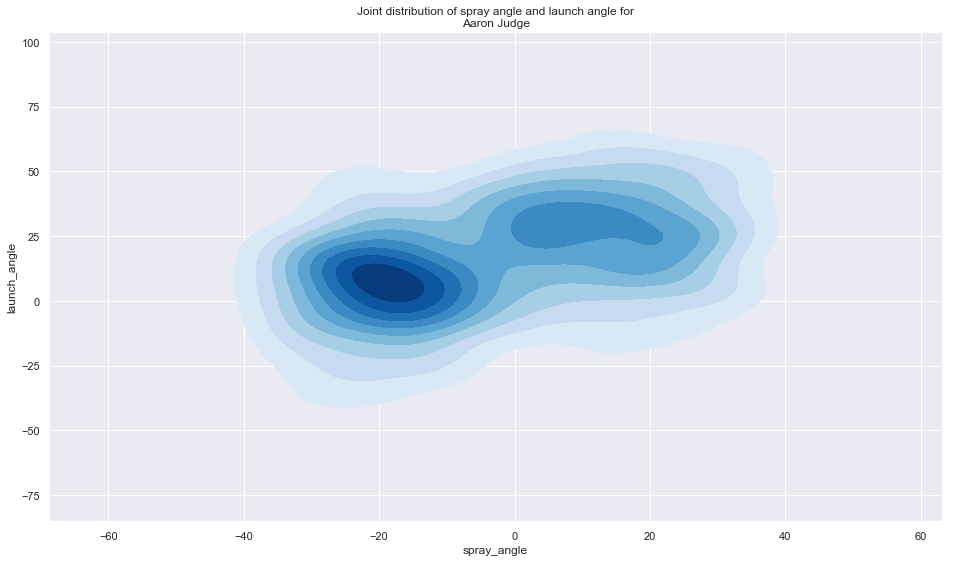

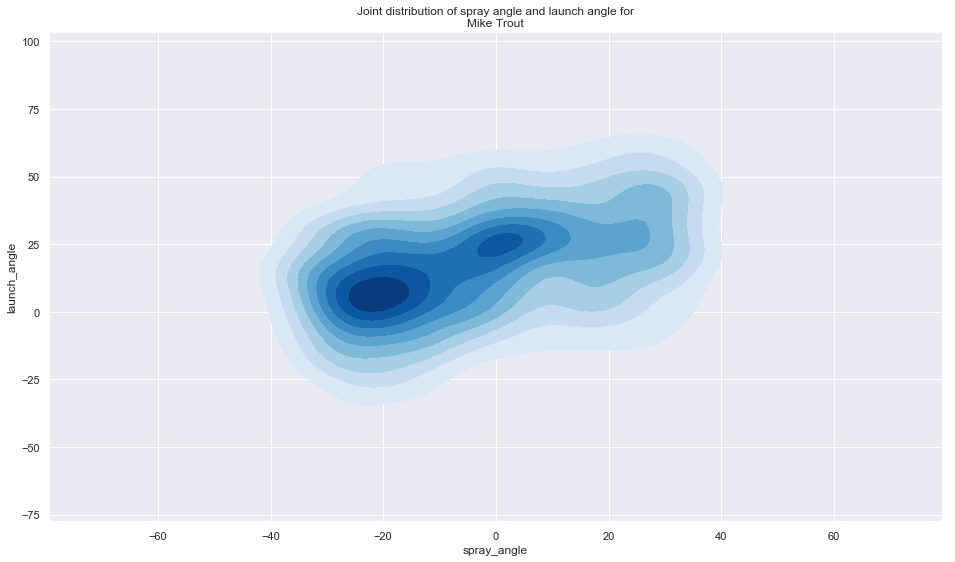

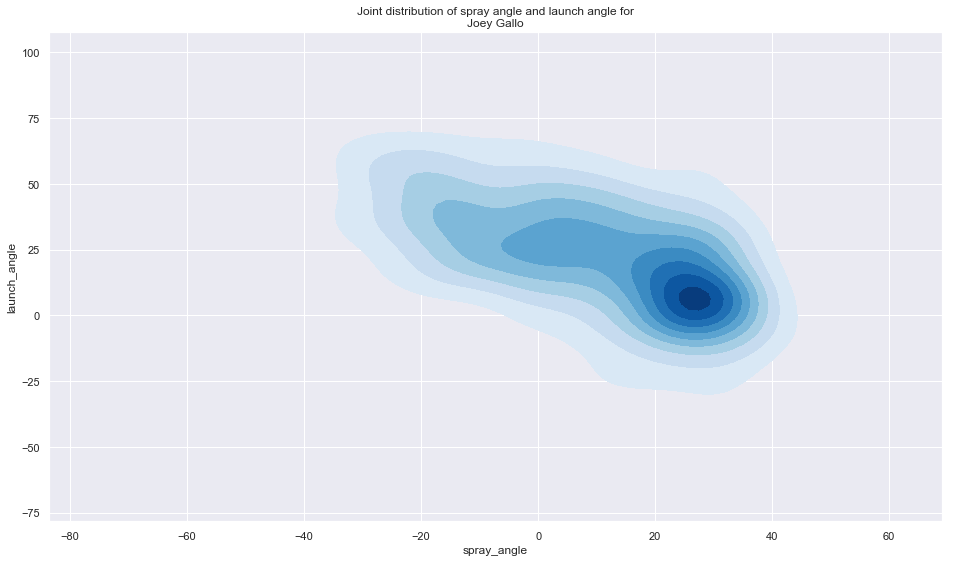

In [90]:
for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    _df = _df[['spray_angle', 'launch_angle', 'launch_speed']]
    _df = _df.dropna()
    
    sns.kdeplot(data=_df['spray_angle'],
                data2=_df['launch_angle'],
                shade=True,
                shade_lowest=False,
                cmap='Blues')
    
    plt.title('Joint distribution of spray angle and launch angle for\n{}'.format(batter))
    plt.show()

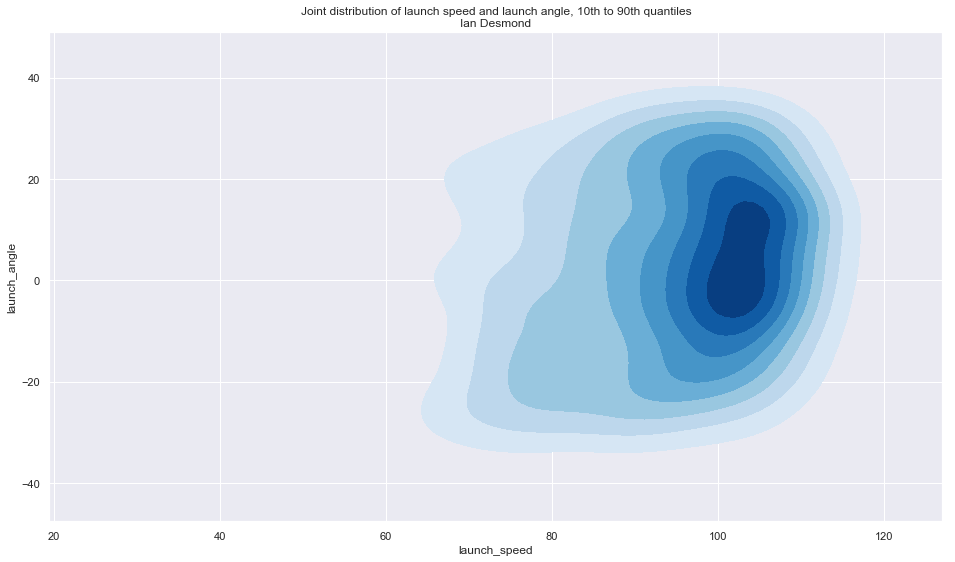

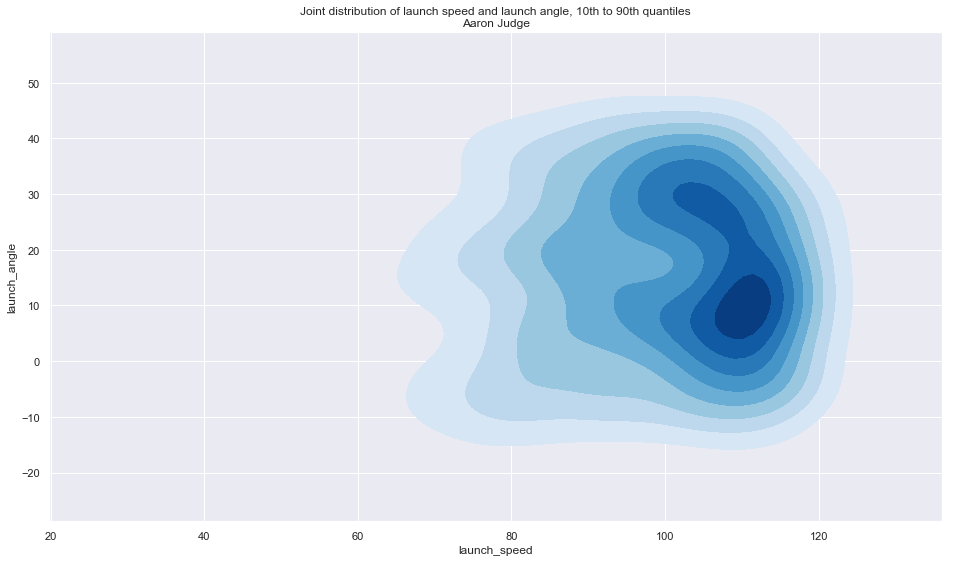

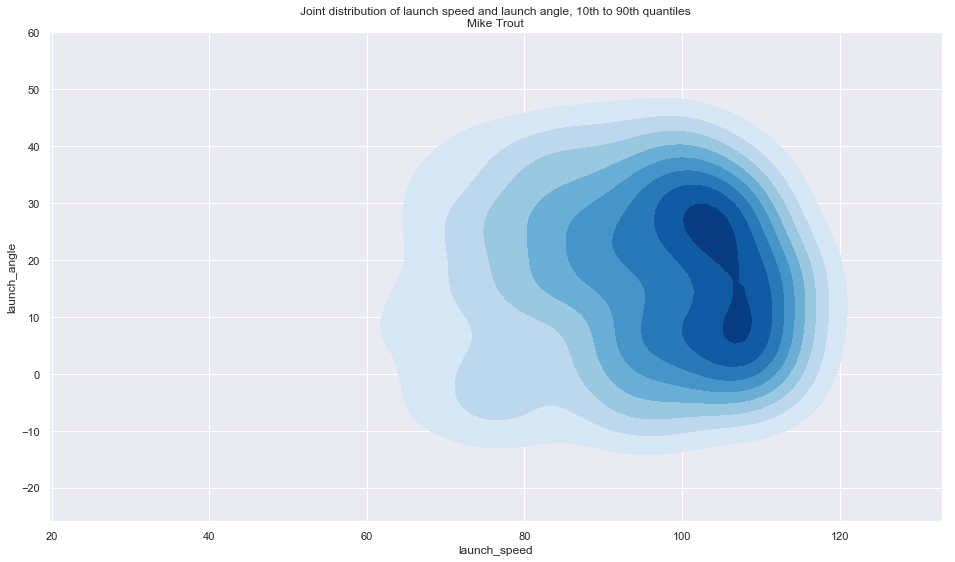

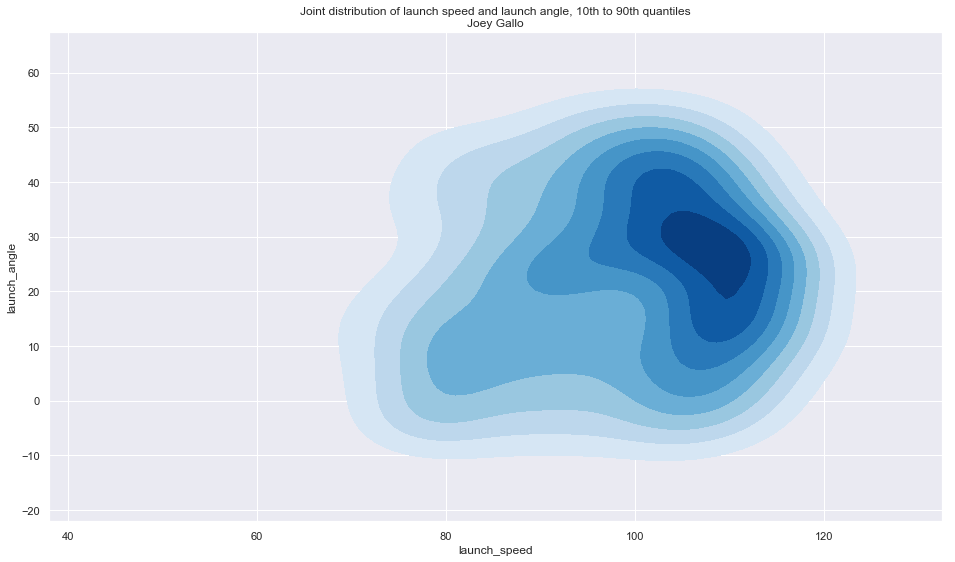

In [91]:
lim_lower = 0.1
lim_higher = 0.9

for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    _low = _df['launch_angle'].quantile(lim_lower)
    _high = _df['launch_angle'].quantile(lim_higher)
    _df = _df[(_df['launch_angle'] > _low) & (_df['launch_angle'] < _high)]
    
    sns.kdeplot(data=_df['launch_speed'], data2=_df['launch_angle'], bw=5, shade=True,
               shade_lowest=False, cmap='Blues')
    
    plt.title('Joint distribution of launch speed and launch angle, {:2.0f}th to {:2.0f}th quantiles\n{}'
              .format(lim_lower * 100, lim_higher * 100, batter))
    plt.show()

### Visualizations by Year

In [92]:
batter_list_yearly = [
    'Mike Trout',
    'Aaron Judge',
    'Joey Gallo',
    'Ian Desmond',
    'Bryce Harper',
    'Didi Gregorius',
    'Gary Sanchez',
    'Brett Gardner',
    'Giancarlo Stanton'
]
df_yearly = df_launch[df_launch['batter_name'].isin(batter_list_yearly)]
df_yearly_no_hr = df_launch_no_hr[df_launch_no_hr['batter_name'].isin(batter_list_yearly)]

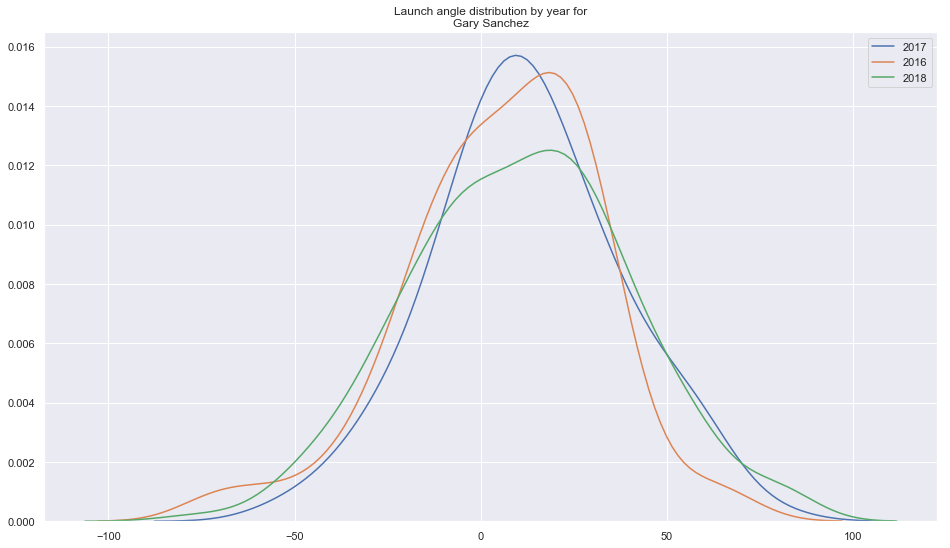

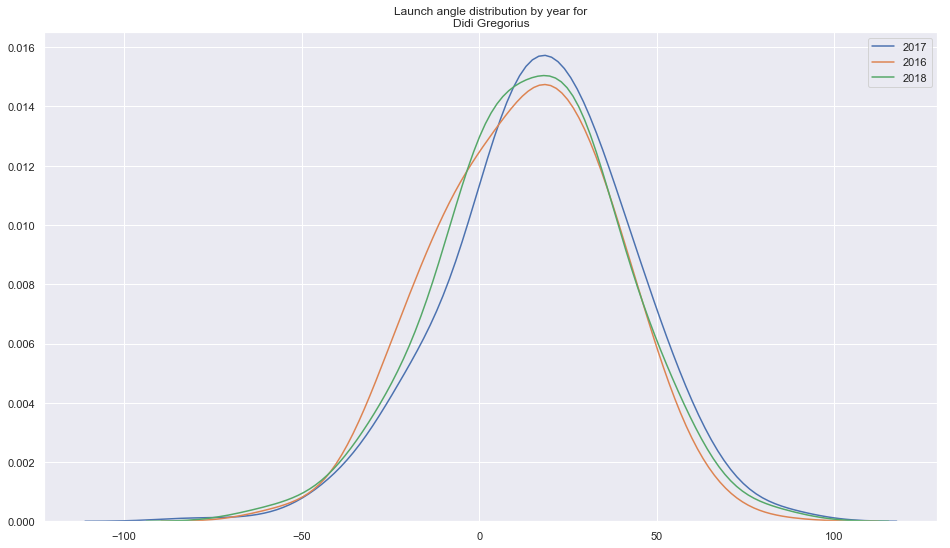

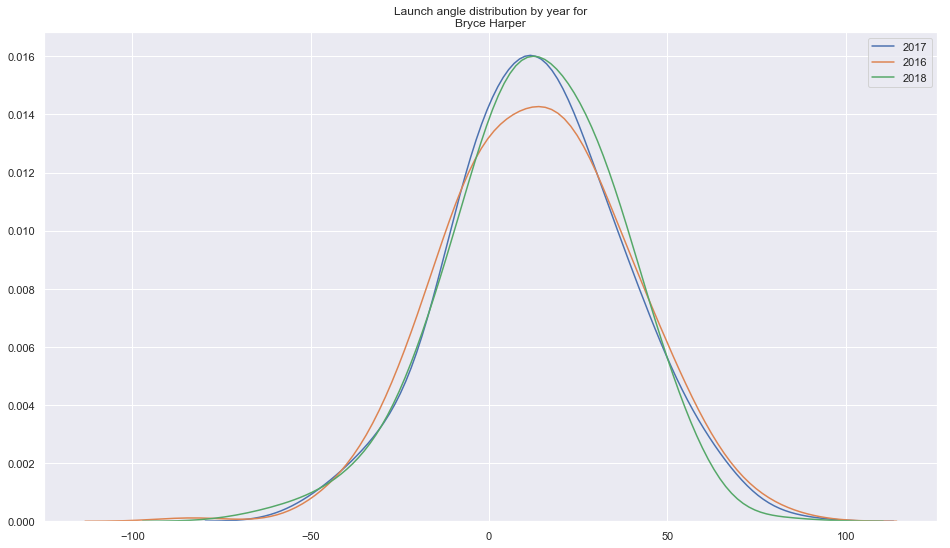

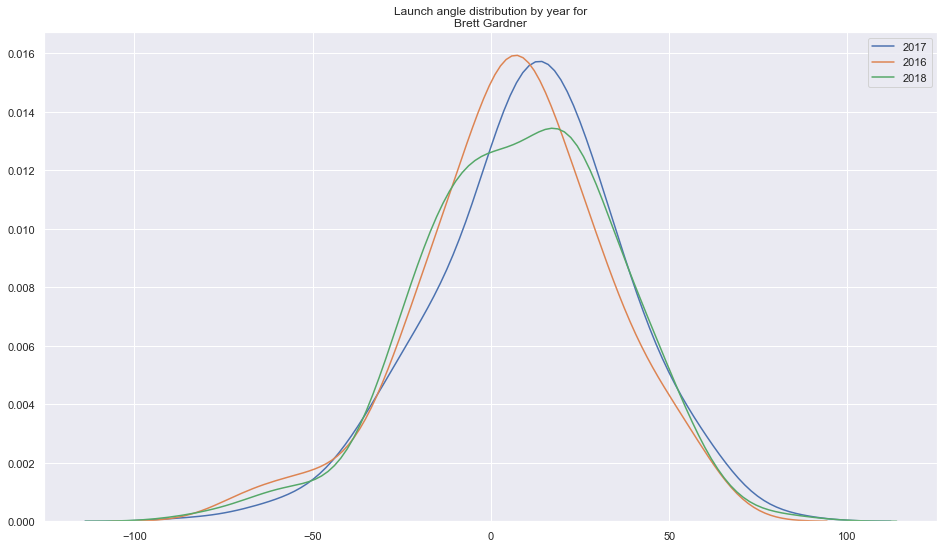

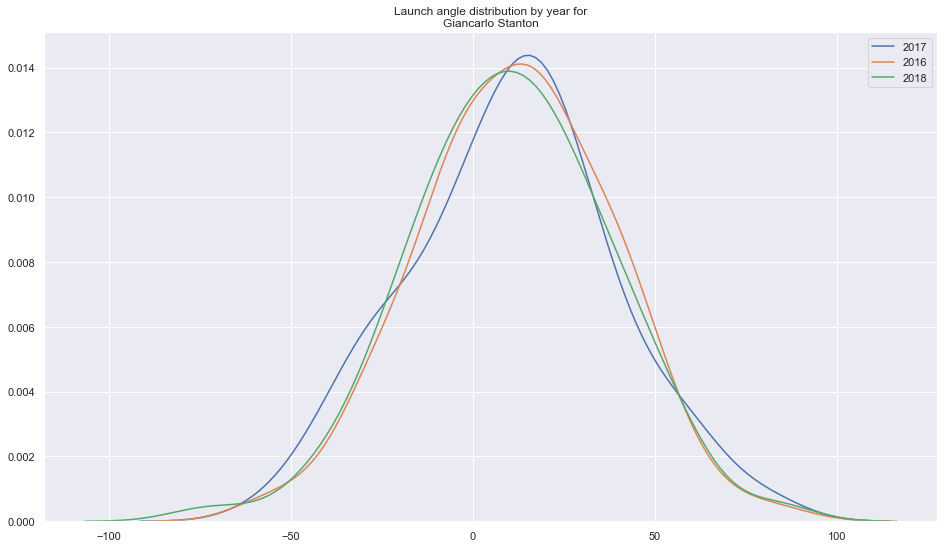

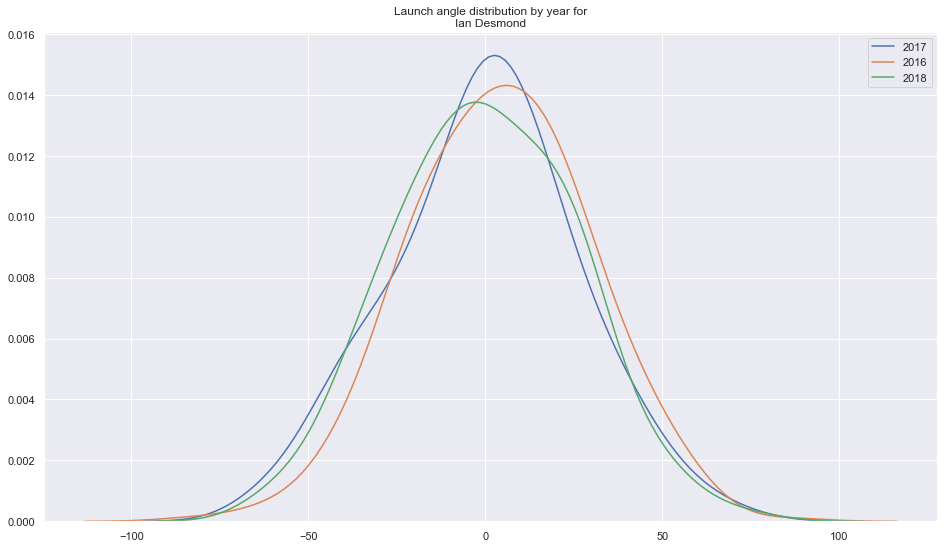

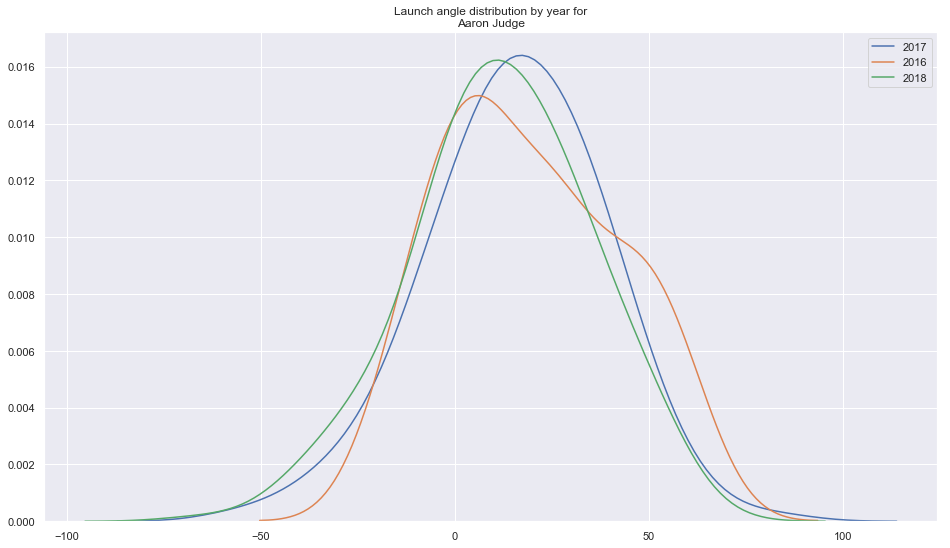

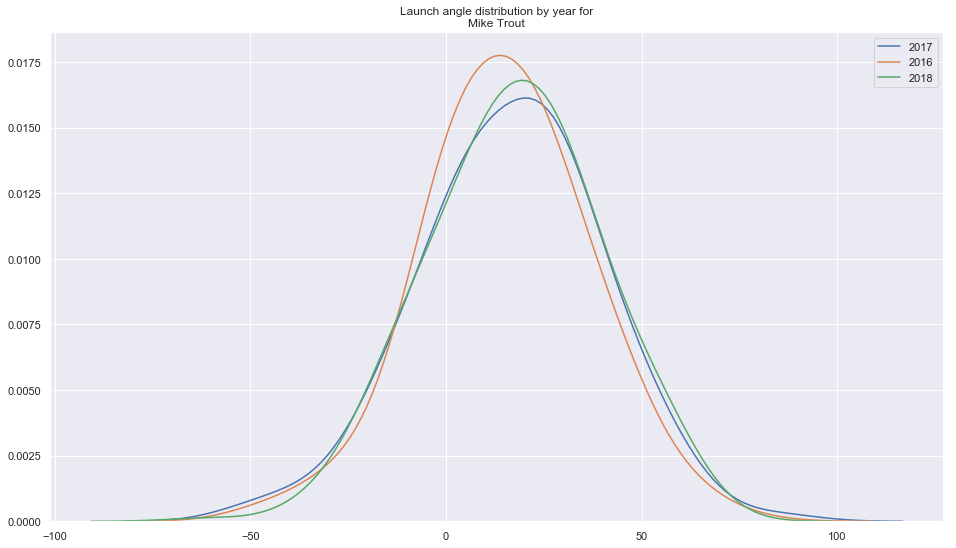

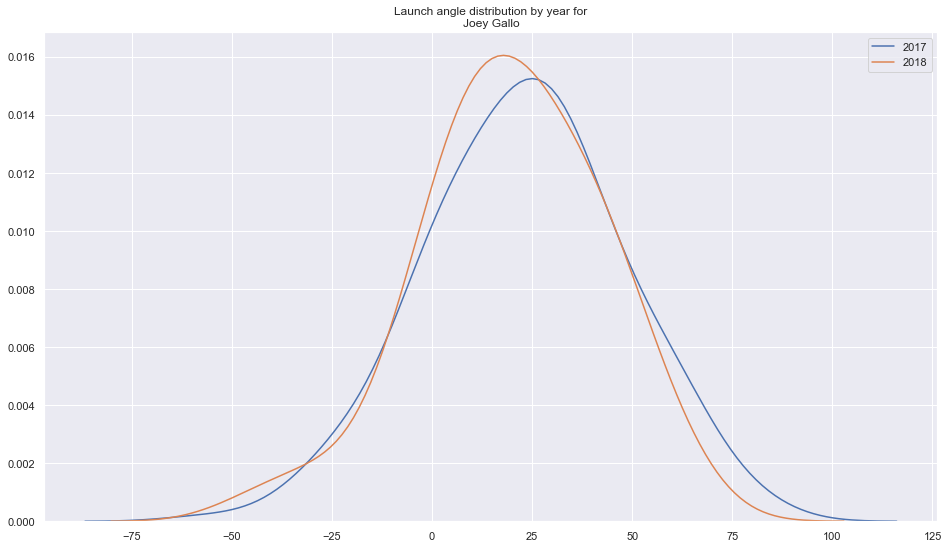

In [96]:
MIN_EVENTS = 25

for batter in df_yearly['batter_name'].unique():
    _df = df_yearly[df_yearly['batter_name'] == batter]
    
    for year in df_yearly['game_year'].unique():
        __df = _df[_df['game_year'] == year]
        
        if __df.shape[0] > MIN_EVENTS:
            sns.kdeplot(data=__df['launch_angle'], bw=10, label=year)

    plt.title('Launch angle distribution by year for\n{}'.format(batter))
    plt.show()